In [1]:
import Pkg; Pkg.add(["Plots", "Polynomials"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; default(l=5, size=(900,550), label=false);
using Printf;
using Polynomials;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

**(follow along: <https://tinyurl.com/gtcse6643lec19>)**

### Warmup

Give $2 \times 2$ examples of:

- A nondefective matrix
- A defective matrix
- A normal matrix
- A matrix with real entries and complex eigenvalues

$$\begin{bmatrix}
\alpha & \\ & \alpha \end{bmatrix}$$

$$\begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}$$

### Course logistics update

1. Homework 4 extended through this weekend

2. Homeworks 5 & 6 combined, assigned after spring break

# Overview of Eigenvalue Algorithms

**1. Review: factorizations and the necessity of iteration**

**2. Example: Power iteration**

**3. General two steps**

**4. Upper Hessenberg factorization**

## Review

- **Eigenvalues / eigenvectors:** There is $x \neq 0$ such that $A x = \lambda x$ $\Leftrightarrow$ $\lambda$ is a root of $p_A(z) = \det(z I - A)$
  - Fundamental theorem of algebra $\Rightarrow$ $A \in \mathbb{C}^{m \times m}$ has $m$ eigenvalues counting with **algebraic multiplicity**

- **Eigenspace** is subspace $E_\lambda$ such tha $A x = \lambda x$ for all $x \in E_\lambda$
  - $\mathrm{dim}(E_\lambda)$ is the **geometric multiplicity**

- geometric multiplicity of $\lambda$ $\leq$ algebraic multiplicity of $\lambda$
  - if strictly less $\lambda$ and $A$ are defective

- $A$ is not defective $\Leftrightarrow$ $A$ has an **eigenvalue decomposition,**

$$A = X \Lambda X^{-1}, \quad \Lambda \text{ diagonal}.$$

  - Furthermore $X = Q$ is unitary $\Leftrightarrow$ $A$ is **normal**,
  
  $$A A^* = A^* A \quad\Leftrightarrow\quad
  A = Q \Lambda Q^*$$

- Every square matrix $A \in \mathbb{C}^{m \times m}$ has a **Schur factorization**,

  $$ A = Q T Q^*, \quad T \text{ upper triangular}.$$
  - Eigenvalues are on the diagonal of $T$
  - Schur factorization is complex even if $A$ is real

- Defining the **companion matrix** C_p of $p(z) = z^m + a_{m-1} z^{m-1} + \cdots + z_0$,
$$
C_p = \begin{bmatrix}
& & & & & -a_0 \\
1 & & & & & -a_1 \\
& 1 & & & & -a_2 \\
& & 1 &  & & \vdots \\
& & & \ddots & & -a_{m-2} \\
& & & & 1 & -a_{m-1}
\end{bmatrix}$$
the roots of $p$ are the eigenvalues of $C_p$.
  

In [4]:
function roots_by_companion(a)
    """
    a = (a₀, a₁, …, aₘ₋₁)
    """
    m = length(a)
    C = zeros(eltype(a),m,m)
    C[:,m] = -a
    for i in 2:m
        C[i,i-1] = 1
    end
    return eigvals(C)
end

roots_by_companion (generic function with 1 method)

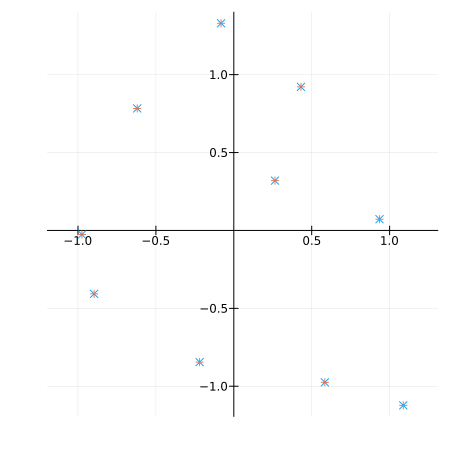

In [5]:
m = 10
as = randn(Complex{Float64},m)
p = Polynomial([as;1])
direct = roots(p)
comp = roots_by_companion(as)
plot(real.([direct comp]), imag.([direct comp])
    , aspect_ratio = :equal
    , st = scatter
    , m = [:x :+]
    , framestyle = :origin
    , size = (450,450)
    )

  - $\Rightarrow$ an **eigenvalue algorithm** is a **root finding algorithm**
  - $\Rightarrow$ an **eigenvalue algorithm must be iterative**

## Example of an iterative eigenvalue algorithm: Power Iteration

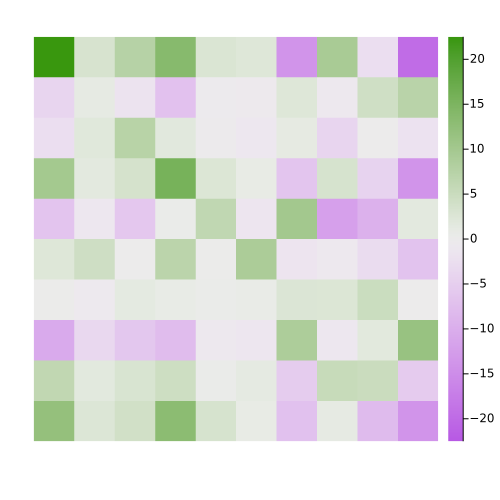

In [45]:
m = 10
Λ = Diagonal(collect(1:m))
X = randn(m, m)
A = (X * Λ) / X
scale = maximum(abs.(A))
imshow(A, clim=(-scale,scale), size=(500,500))

In [46]:
x_init = randn(m)
x_init /= norm(x_init)

10-element Vector{Float64}:
  0.014956975750314069
  0.0417233836385678
  0.2506739959173118
 -0.4001086624073702
 -0.3004836302091261
  0.3166483035529444
 -0.23016508050096354
 -0.03219630878362477
  0.5000060364427165
 -0.5296563895059824

In [48]:
x = copy(x_init)
n_iter = 100
for i in 1:n_iter
    Ax = A * x
    λ = norm(Ax)
    display(λ)
    x = Ax / λ
end

17.530466951370823

9.939312401167987

8.498350990802395

8.296241512580321

8.384503691451732

8.55445795251674

8.747480879653063

8.945521411337515

9.139500227336029

9.321195706078603

9.483219156952257

9.620720510294952

9.732226696276975

9.819189093535792

9.884848679896615

9.933108519694548

9.967758620520465

9.992083200770036

10.008740411205467

10.019791568327776

10.026792391882985

10.030897104288035

10.032952949950085

10.033577693269292

10.033219786559727

10.03220365423947

10.030763175987493

10.02906620783344

10.027232460302612

10.025346518020436

10.023467329377008

10.021635137502093

10.019876555712385

10.018208294345664

10.016639904168438

10.015175799875554

10.013816754441196

10.01256100297982

10.011405057374253

10.010344305975753

10.009373453168012

10.00848683938765

10.007678671805479

10.006943188231881

10.006274771159674

10.005668024659297

10.005117823706257

10.004619343170075

10.00416807192426

10.003759816200246

10.003390695295598

10.003057131977755

10.0027558393398

10.002483805419173

10.002238276550825

10.00201674016771

10.001816907564788

10.001636696993108

10.001474217337499

10.001327752545969

10.001195746915052

10.001076791287755

10.000969610185786

10.000873049872595

10.000786067325544

10.000707720083351

10.000637156926796

10.00057360934551

10.000516383741441

10.00046485431831

10.000418456607168

10.00037668157919

10.000339070298917

10.00030520907342

10.000274725055458

10.000247282261313

10.000222577966742

10.00020033944728

10.000180321031493

10.000162301438513

10.000146081373419

10.0001314813564

10.000118339763514

10.000106511059094

10.00009586420132

10.000086281204508

10.000077655842832

10.00006989248188

10.00006290502558

10.000056615967251

10.000050955534595

10.000045860919435

10.000041275583836

10.000037148635156

10.000033434263147

10.000030091233073

10.000027082429222

10.000024374443859

10.000021937207132

10.00001974365386

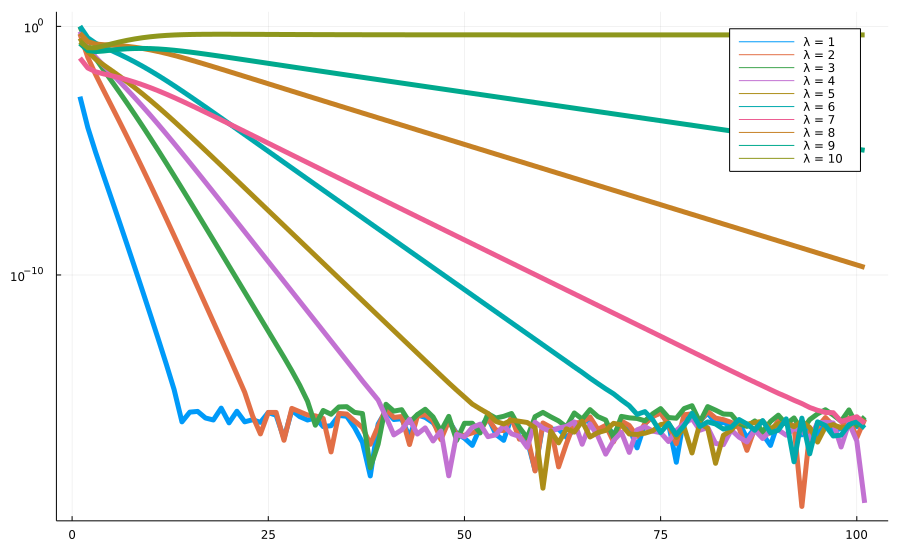

In [49]:
x = copy(x_init)
n_iter = 100
c = zeros(m, n_iter+1)
for i in 1:n_iter
    c[:,i] = X \ x
    Ax = A * x
    λ = norm(Ax)
    x = Ax / λ
end
c[:,end] = X \ x
plot(1:(n_iter+1), abs.(c)', yscale=:log10, labels=["λ = $j" for i in 1:1, j in 1:m])

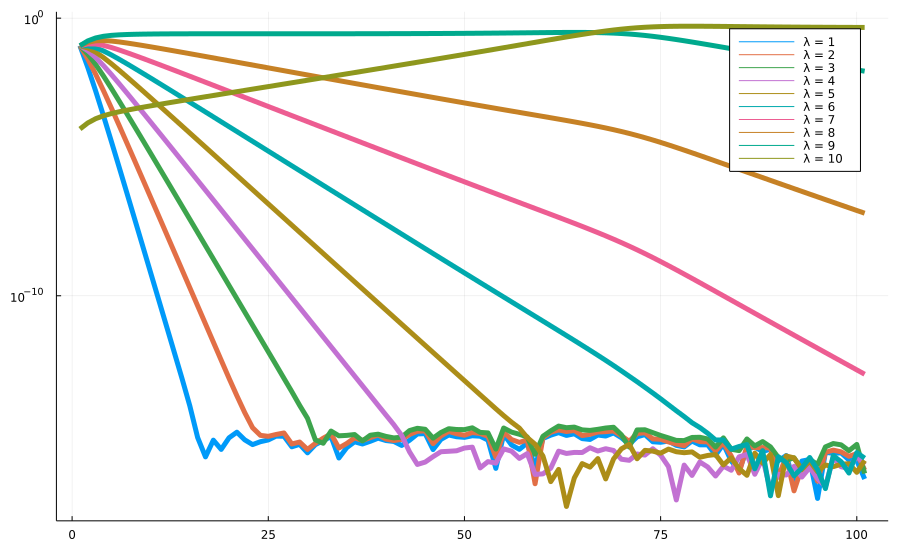

In [50]:
c_init = ones(m)
c_init[m] = 1.e-3
x_init = X * c_init
x = x_init / norm(x_init)
n_iter = 100
c = zeros(m, n_iter+1)
for i in 1:n_iter
    c[:,i] = X \ x
    Ax = A * x
    λ = norm(Ax)
    x = Ax / λ
end
c[:,end] = X \ x
plot(1:(n_iter+1), abs.(c)', yscale=:log10, labels=["λ = $j" for i in 1:1, j in 1:m])

- What about a matrix with real entries and complex eigenvalues?

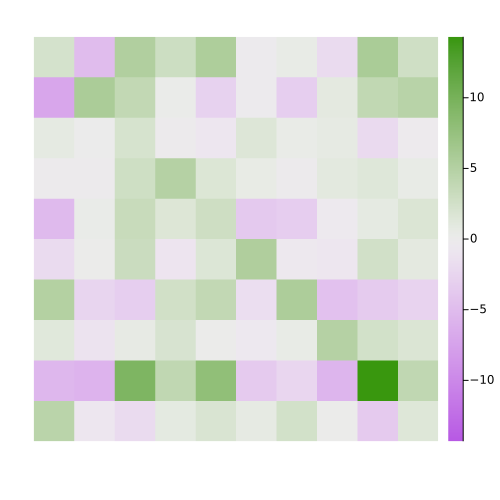

In [51]:
m = 10
Λ = diagm(collect(1.0:m))
Λ[m-1:m,m-1:m] = m * [[1.0,1.0] [-1.0,1.0]] / sqrt(2)
X = randn(m, m)
A = (X * Λ) / X
scale = maximum(abs.(A))
imshow(A, clim=(-scale,scale), size=(500,500))

In [52]:
eigvals(A)

10-element Vector{ComplexF64}:
 1.0000000000000033 + 0.0im
 1.9999999999999987 + 0.0im
                3.0 + 0.0im
 3.9999999999999907 + 0.0im
  4.999999999999998 + 0.0im
  6.000000000000005 + 0.0im
  7.000000000000003 + 0.0im
  7.071067811865475 - 7.07106781186548im
  7.071067811865475 + 7.07106781186548im
  8.000000000000005 + 0.0im

In [55]:
x = randn(m)
x /= norm(x)
n_iter = 100
for i in 1:n_iter
    j = argmax(abs.(x))
    Ax = A * x
    λ = Ax[j] / x[j]
    display(λ)
    x = Ax / λ
end

5.057594870938997

10.847645111421249

5.7240494903140755

3.0467406782800537

5.506108325679989

11.996534978438781

5.660635272710407

8.872598742878512

2.9668407544934827

11.76378411866203

5.6499140022286785

2.669255106787655

2.895723849282023

11.782306635487396

5.659827724629643

8.903300102571574

2.9182835520296195

11.78700682697941

5.654626377557424

8.905690269995926

2.9106347896832268

11.78286387090847

5.657011226380282

8.904928993567097

2.913383770055624

11.784996936012964

5.655976986951783

8.905186566791723

2.9123540420052567

11.784030137311804

5.656414253625592

8.905094537067788

2.912752392136592

11.784446788241764

5.656231963827796

8.905128910298423

2.9125949384858565

11.784271347373158

5.65630739630023

8.905115639552385

2.9126580546971352

11.784344324860205

5.656276317280261

8.905120879424306

2.9126325345069732

11.784314167701782

5.6562890910510415

8.90511878038153

2.9126429077391642

11.784326583258592

5.656283848450961

8.905119628784378

2.9126386780646136

11.78432148270919

5.656285998337376

8.905119284010414

2.912640405928587

11.784323575517258

5.656285117140842

8.905119424573371

2.9126396993032118

11.784322717433458

5.656285478223899

8.905119367156443

2.912639988471017

11.784323069113132

5.656285330289507

8.90511939063655

2.912639870091747

11.784322925015058

5.656285390891784

8.905119381028188

2.912639918564559

11.784322984049645

5.656285366067085

8.905119384961587

2.9126398987137745

11.784322959866188

5.656285376235759

8.905119383350991

2.9126399068437694

11.78432296977242

5.656285372070551

8.90511938401056

2.912639903513931

11.784322965714656

5.656285373776648

8.905119383740427

2.912639904877777

11.784322967376754

5.656285373077822

8.905119383851064

2.912639904319157

11.784322966695948

5.656285373364061

8.905119383805745

2.9126399045479627

11.784322966974802

5.656285373246813

8.905119383824303

In [14]:
x = randn(Complex{Float64}, m)
x /= norm(x)
n_iter = 10
for i in 1:n_iter
    j = argmax(abs.(x))
    Ax = A * x
    λ = Ax[j] / x[j]
    display(λ)
    x = Ax / norm(Ax)
end

9.296534608436936 - 2.8231873680954043im

8.687502362923325 - 0.5431705220584377im

9.441544565438099 - 4.1878701117908195im

8.22476222202535 - 2.725039466888209im

10.303684559307092 - 3.5689116266779948im

5.938713764710407 - 3.1931765887154153im

1.567967000728546 - 6.778729385133586im

6.196651536966775 - 3.249094685855716im

10.213572545030711 - 4.618725604319145im

5.8223345951188 - 3.821980026639795im

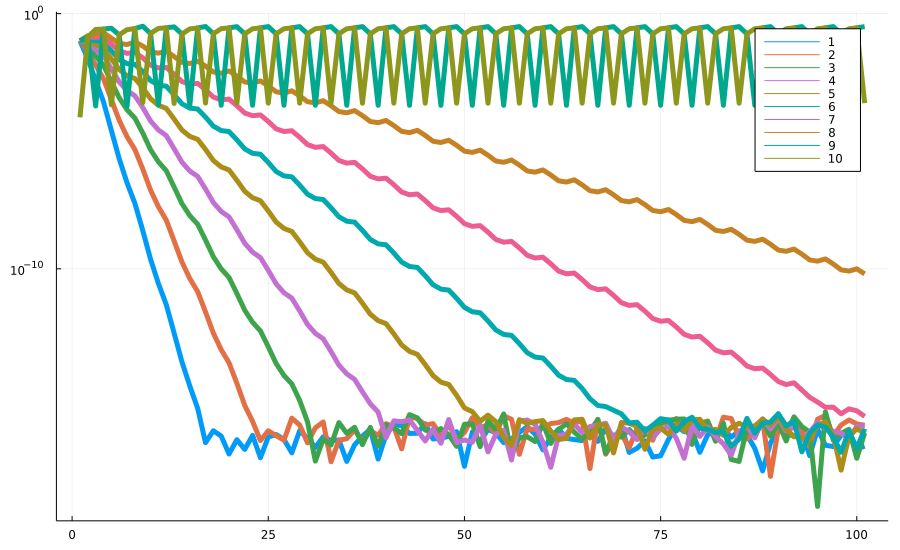

In [15]:
c_init = ones(m)
c_init[m] = 1.e-3
x_init = X * c_init
x = x_init / norm(x_init)
n_iter = 100
c = zeros(m, n_iter+1)
for i in 1:n_iter
    c[:,i] = X \ x
    Ax = A * x
    x = Ax / norm(Ax)
end
c[:,end] = X \ x
plot(1:(n_iter+1), abs.(c)', yscale=:log10, labels=["$j" for i in 1:1, j in 1:m])

> The best general purpose eigenvalue algorithms are [...] the computation of an eigenvalue-revealing factorization of $A$, where the eigenvalues appear as entries of one of the factors.

## Schur factorization and Diagonalization

We compute a Schur factorization $A = QTQ^*$ by transforming $A$ by a sequence of elementary unitary similarity transformations $X \mapsto Q_j^* X Q_j$.  We want

$$
\underbrace{Q_j^* \cdots Q_2^* Q_1^*}_{Q^*} A \underbrace{Q_1 Q_2 \cdots Q_j}_{Q}
$$

to converge rapidly to an upper triangular matrix $T$ as $j \to \infty$.

**Claim.** If $A$ is a normal matrix, $T$ is diagonal.

### Two phases of eigenvalue computations

1. A direct method is applied to produce an **upper Hessenberg matrix** (a matrix with zeros below the diagonal below the main diagonal)

$$
H = \begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
& \times & \times & \times & \times \\
& & \times & \times & \times \\
& & & \times & \times \\
\end{bmatrix}
$$

2. An iteration is appled to generate a (formally infinite) sequence of Hessenberg matrices that converges to a triangular form.

### $A$ is nonhermitian

$$
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\end{bmatrix}}_{A}
\quad
\stackrel{\text{Phase 1}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
& \times & \times & \times & \times \\
& & \times & \times & \times \\
& & & \times & \times \\
\end{bmatrix}}_{H}
\quad
\stackrel{\text{Phase 2}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
& \times & \times & \times & \times \\
& & \times & \times & \times \\
& & & \times & \times \\
& & & & \times \\
\end{bmatrix}}_{T}
$$

- Phase 1: $O(m^3)$ operations
- Phase 2: $O(m^2)$ operations **per iteration** ($O(m^3)$ if we did not do phase 1)

### $A$ is hermitian

$$
\underbrace{\begin{bmatrix}
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\times & \times & \times & \times & \times \\
\end{bmatrix}}_{A}
\quad
\stackrel{\text{Phase 1}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times & \times & & & \\
\times & \times & \times & & \\
& \times & \times & \times & \\
& & \times & \times & \times \\
& & & \times & \times \\
\end{bmatrix}}_{T}
\quad
\stackrel{\text{Phase 2}}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\times &  &  &  & \\
& \times & & & \\
& & \times & & \\
& & & \times & \\
& & & & \times \\
\end{bmatrix}}_{D}
$$

- Phase 1: $O(m^3)$ operations
- Phase 2: $O(m)$ operations **per iteration** ($O(m^3)$ if we did not do phase 1)

### Exercise

**T&B Exercise 25.1.** 

- Let $A \in \mathbb{C}^{m \times m}$ be tridiagonal and Hermitian, with all its sub- and superdiagonal entries nonzero.  Prove that the eigenvalues of $A$ are distinct.

- Let $A$ be upper-Hessenberg, with all its subdiagonal entries nonzero.  Give an example that shows that the eigenvalues of $A$ are not necessarily distinct.

## Reduction to Hessenberg or Tridiagonal Form

### A Bad Idea

We cannot be too greedy when trying to make the matrix triangular

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ
\end{bmatrix}}_{A}
\quad
\stackrel{Q_1^*}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\bullet & \bullet & \bullet & \bullet & \bullet \\
 & \bullet & \bullet & \bullet & \bullet \\
  & \bullet & \bullet & \bullet & \bullet \\
   & \bullet & \bullet & \bullet & \bullet \\
    & \bullet & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_1^* A}
\quad
$$

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ
\end{bmatrix}}_{Q_1^* A}
\quad
\stackrel{Q_1}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\bullet & \bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet & \bullet \\
\bullet & \bullet & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_1^* A Q_1}
\quad
$$

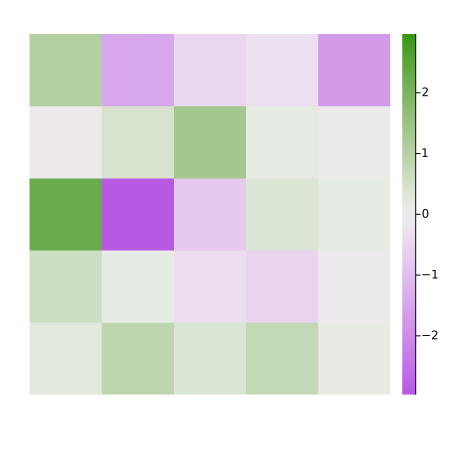

In [16]:
m = 5
A = randn(m,m)
scale = maximum(abs.(A))
imshow(A, clim=(-scale, scale), size=(450,450))

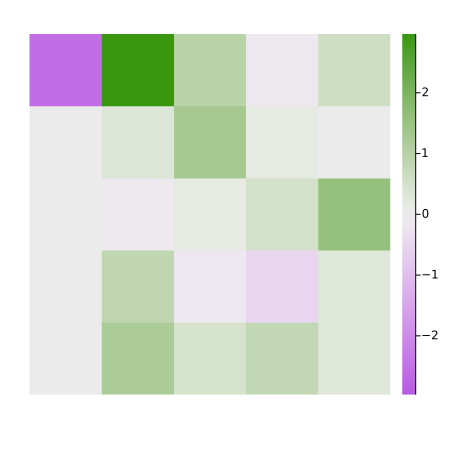

In [17]:
q = A[:,1]
z = copy(q)
z[1] += sign(q[1]) * norm(q)
Q = I - 2. * z * z' / (z' * z)
QA = Q' * A
imshow(QA, clim=(-scale,scale), size=(450,450))

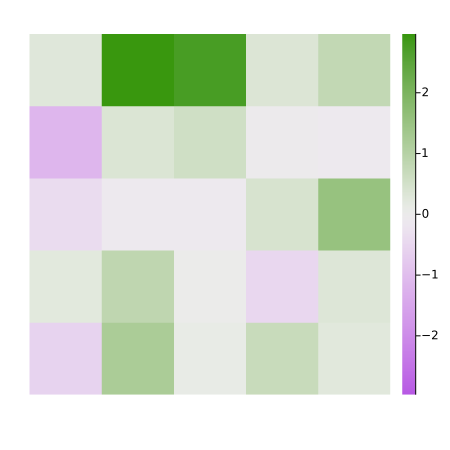

In [18]:
QAQ = QA * Q
imshow(QAQ, clim=(-scale,scale), size=(450,450))

- This had to fail: otherwise we would have a direct computation of eigenvalues

### A Good Idea

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ
\end{bmatrix}}_{A}
\quad
\stackrel{Q_1^*}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\bullet & \bullet & \bullet & \bullet & \bullet \\
 & \bullet & \bullet & \bullet & \bullet \\
  & \bullet & \bullet & \bullet & \bullet \\
   & \bullet & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_1^* A}
\quad
$$

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ \\
 & \circ & \circ & \circ & \circ
\end{bmatrix}}_{Q_1^* A}
\quad
\stackrel{Q_1}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\circ & \bullet & \bullet & \bullet & \bullet \\
\circ & \bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet & \bullet \\
& \bullet & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_1^* A Q_1}
\quad
$$

(4, 4)

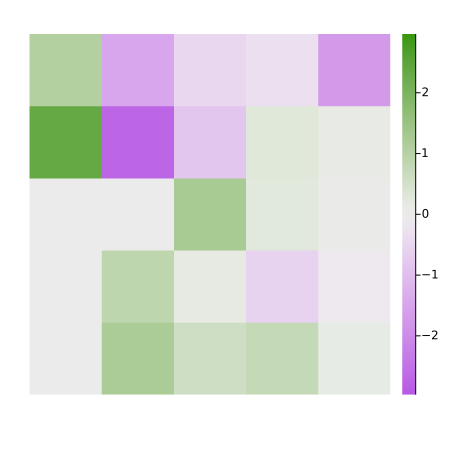

In [19]:
q = A[2:end,1]
z = copy(q)
z[1] += sign(q[1]) * norm(q)
Q = I - 2. * z * z' / (z' * z)
display(size(Q))
QA = [A[[1],:]; Q' * A[2:end,:]]
imshow(QA, clim=(-scale,scale), size=(450,450))

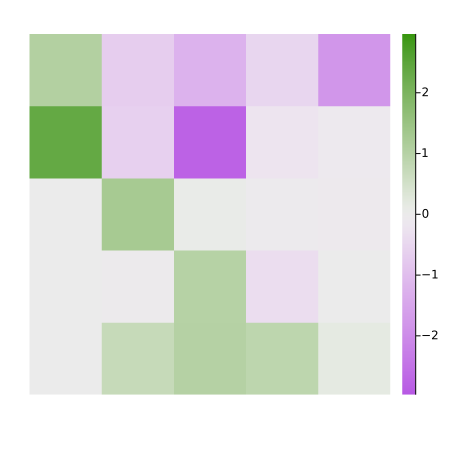

In [20]:
QAQ = [QA[:,1] QA[:,2:end] * Q]
imshow(QAQ, clim=(-scale,scale), size=(450,450))

$$
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
& \circ & \circ & \circ & \circ \\
& \circ & \circ & \circ & \circ \\
& \circ & \circ & \circ & \circ
\end{bmatrix}}_{Q_1^* A Q_1}
\quad
\stackrel{Q_2^*}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\circ & \circ & \circ & \circ & \circ \\
\circ & \circ & \circ & \circ & \circ \\
 & \bullet & \bullet & \bullet & \bullet \\
  & & \bullet & \bullet & \bullet \\
   & & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_2^* Q_1^* A Q_1}
\quad
\stackrel{Q_2}{\longrightarrow}
\quad
\underbrace{\begin{bmatrix}
\circ & \circ & \bullet & \bullet & \bullet \\
\circ & \circ & \bullet & \bullet & \bullet \\
& \circ & \bullet & \bullet & \bullet \\
& & \bullet & \bullet & \bullet \\
& & \bullet & \bullet & \bullet
\end{bmatrix}}_{Q_2^* Q_1^* A Q_1 Q_2}
$$

In [21]:
function householder_to_hessenberg(A)
    m = size(A)[1]
    Q = Matrix(one(eltype(A))*I,m,m)
    H = copy(A)
    for k in 1:m-2
        x = H[k+1:m,k]
        vₖ = copy(x)
        vₖ[1] += norm(x) * sign(x[1])
        vₖ /= norm(vₖ) 
        H[k+1:m,k:m] -= 2 * vₖ * (vₖ' * H[k+1:m,k:m]) # Qₖ' on left
        H[1:m,k+1:m] -= 2 * (H[1:m,k+1:m] * vₖ) * vₖ' # Qₖ on right
        Q[:,k+1:m] = Q[:,k+1:m] * (I - 2 * vₖ * vₖ')
    end
    return Q, H
end

householder_to_hessenberg (generic function with 1 method)

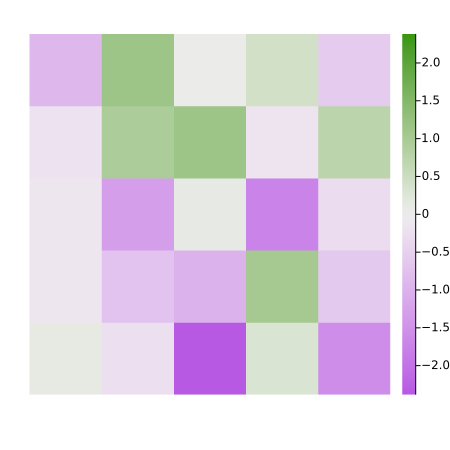

In [22]:
A = randn(m,m)
scale = maximum(abs.(A))
imshow(A, clim=(-scale, scale), size=(450,450))

3.7757849473428284e-15

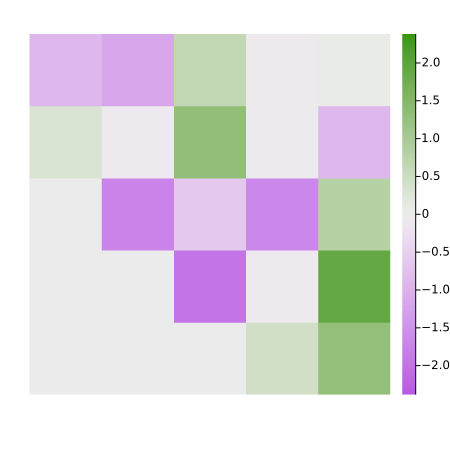

In [23]:
Q, H = householder_to_hessenberg(A)
display(norm(Q * H * Q' - A))
imshow(H, clim=(-scale, scale), size=(450,450))

### Operation Count

In [24]:
function householder_to_hessenberg(A)
    m = size(A)[1]
    Q = Matrix(one(eltype(A))*I,m,m)
    H = copy(A)
    for k in 1:m-2
        x = H[k+1:m,k]
        vₖ = copy(x)
        vₖ[1] += norm(x) * sign(x[1])
        vₖ /= norm(vₖ)
        H[k+1:m,k:m] -= 2 * vₖ * (vₖ' * H[k+1:m,k:m]) # ~ 4 (m-k) (m-k-1)
        H[1:m,k+1:m] -= 2 * (H[1:m,k+1:m] * vₖ) * vₖ' # ~ 4 m (m-k)
        Q[:,k+1:m] = Q[:,k+1:m] * (I - 2 * vₖ * vₖ')
    end
    return Q, H
end

householder_to_hessenberg (generic function with 1 method)

- Line 10: $\sum_{k=1}^{m-2} 4(m-k)(m-k-1) \sim 4 \int_0^m k^2\ dk = \frac{4}{3} m^3.$

- Line 11: $\sum_{k=1}^{m-2} 4 m (m-k) \sim 4 m \int_0^m k\ dk = 2 m^3$

- $\Rightarrow \frac{10}{3} m^3$ flops

### The Hermitian Case: Reduction to Tridiagonal Form

In [25]:
function householder_to_triangular(A)
    m = size(A)[1]
    Q = Matrix(one(eltype(A))*I,m,m)
    H = copy(A)
    for k in 1:m-2
        x = H[k+1:m,k]
        vₖ = copy(x)
        vₖ[1] += norm(x) * sign(x[1])
        vₖ /= norm(vₖ)
        H[k+1:m,k:m] -= 2 * vₖ * (vₖ' * H[k+1:m,k:m]) # Qₖ' on left
        H[k:m,k+1:m] -= 2 * (H[k:m,k+1:m] * vₖ) * vₖ' # Qₖ on right
        Q[:,k+1:m] = Q[:,k+1:m] * (I - 2 * vₖ * vₖ')
    end
    return Q, H
end

householder_to_triangular (generic function with 1 method)

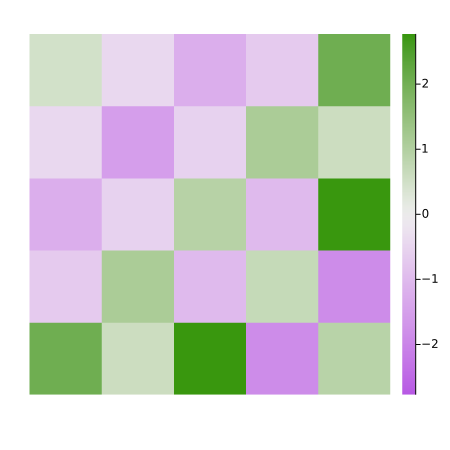

In [26]:
A = randn(m,m)
A = A + A'
scale = maximum(abs.(A))
imshow(A, clim=(-scale, scale), size=(450,450))

2.9131456721125218e-15

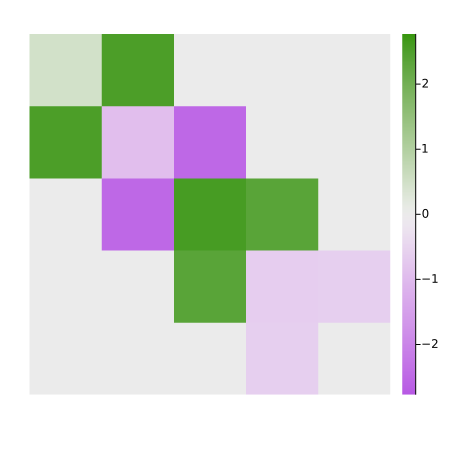

In [27]:
Q, H = householder_to_triangular(A)
display(norm(Q * H * Q' - A))
imshow(H, clim=(-scale, scale), size=(450,450))

In [28]:
function householder_to_triangular(A)
    m = size(A)[1]
    Q = Matrix(one(eltype(A))*I,m,m)
    H = copy(A)
    for k in 1:m-2
        x = H[k+1:m,k]
        vₖ = copy(x)
        vₖ[1] += norm(x) * sign(x[1])
        vₖ /= norm(vₖ)
        H[k+1:m,k:m] -= 2 * vₖ * (vₖ' * H[k+1:m,k:m]) # 4 (m-k)(m-k-1)
        H[k:m,k+1:m] -= 2 * (H[k:m,k+1:m] * vₖ) * vₖ' # 4 (m-k-1)(m-k)
        Q[:,k+1:m] = Q[:,k+1:m] * (I - 2 * vₖ * vₖ')
    end
    return Q, H
end

householder_to_triangular (generic function with 1 method)

### Operation Count

- $\sim 2 \frac{4}{3} m^3 = \frac{8}{3} m^3$, but this doesn't take advantage of symmetry
- This can be exploited to reduce by half the number of updated entries, $\frac{4}{3}m^3$ work

### Stability

**Theorem 26.1.** Let the Hessenberg reduction $A = QHQ^*$ of a matrix $A \in C^{m \times m}$ be computed by `householder_to_hessenberg` on a computer satisfying the floating point axioms, and let the computed factors $\tilde{Q}$ and $\tilde{H}$ be computed factors, with $\tilde{Q}$ the exact product of exactly unitary Householder reflectors from computed $\tilde{v}_k$.  Then

$$
\tilde{Q} \tilde{H} \tilde{Q}^* = A + \delta A, \quad \frac{\|\delta A\|}{\|A\|} = O(\epsilon_{\text{machine}})
$$

for some $\delta A$.